In [1]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
import imageio
%matplotlib inline

In [2]:
from comet_ml import Experiment
# Add the following code anywhere in your machine learning file
experiment = Experiment(api_key="kYVqzmHEUN7WQLo86k2bZs1Z7",
                        project_name="mri-epilepsy-segmentation", workspace="kondratevakate")

from tqdm import tqdm_notebook, tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models.vgg import vgg11_bn
from torch.autograd import Function, Variable
import random
import numpy as np

import sys
import os
from optparse import OptionParser

import torch.backends.cudnn as cudnn
from torch import optim
import time

import pandas as pd

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/kondratevakate/mri-epilepsy-segmentation/0b4a4fd909574b5b92ed805a2e7a72ee



In [3]:
!nvidia-smi

Sat May 30 22:19:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:02:00.0 Off |                  N/A |
| 27%   27C    P8    21W / 260W |      0MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
import sys
sys.path.append("..")

# import utils 
from utils.viz_tools import plot_central_cuts, plot_predicted
from utils.data import MriSegmentation

  0%|          | 0/30 [00:00<?, ?it/s]

Assembling data for:  pirogov  sample.


100%|██████████| 30/30 [00:02<00:00, 14.62it/s]


Dataset size: 30
Labels distribution: (array([1]), array([30]))

Image shape: torch.Size([1, 192, 192, 192])
Segmentation shape: torch.Size([1, 192, 192, 192])


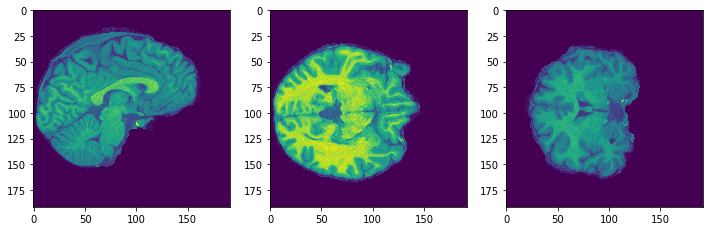

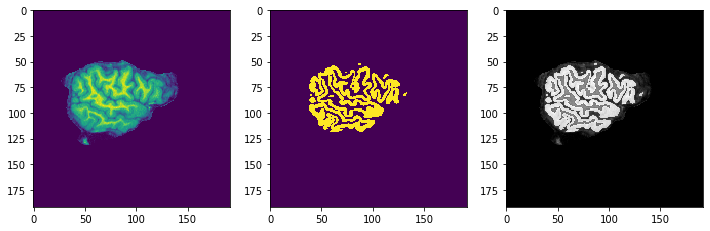

In [5]:
data_params = {
    'sample':'pirogov', 
    'mask':'seg', 
    'ignore_missing':'True',
#     'coord_min':(30, 30, 30),
#     'img_shape' :(192, 192, 192)
}

fcd_data = MriSegmentation(**data_params)

print("Dataset size: {}".format(len(fcd_data)))
print("Labels distribution: {}\n".format(np.unique(fcd_data.target, return_counts=True)))
img, mask = fcd_data[3]
print("Image shape: {}".format(img.shape))
print("Segmentation shape: {}".format(mask.shape))
plot_central_cuts(img)
plot_predicted(img, mask, delta = -50, title="")

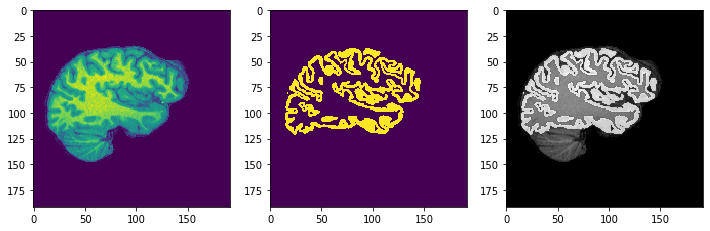

In [6]:
plot_predicted(img, mask, delta = 40, title="")

## 1. Training w/o data augmentation

### 1.1. Bounding box annotation

In [7]:
from routine import *

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Link: https://arxiv.org/abs/2003.04696



In [8]:
from torchio.transforms import HistogramStandardization

histogram_landmarks_path = 'weights/fcd_train_data_landmarks.npy'

# image_paths = list(fcd_data.img_files[train_idx].values)

# landmarks = HistogramStandardization.train(
#     image_paths,
#     output_path=histogram_landmarks_path,
# )
landmarks = np.load(histogram_landmarks_path)

print(landmarks.shape)

(13,)


In [9]:
cv = ShuffleSplit(n_splits = 1,  test_size = 0.3, random_state = 42)
cv_splits = list(cv.split(X=np.arange(len(fcd_data)), y=fcd_data.target))

training_transform = Compose([
#     RescaleIntensity((0, 1)),  # so that there are no negative values for RandomMotion
#     RandomMotion(),
#     HistogramStandardization(landmarks_dict={MRI: landmarks}),
#     RandomBiasField(),
#     ZNormalization(masking_method=ZNormalization.mean),
    CropOrPad((192, 192, 192)),
#     RandomFlip(axes=(0,)),
#     OneOf({
#         RandomAffine(): 0.8,
#         RandomElasticDeformation(): 0.2,
#     }),
])

validation_transform = Compose([
#     HistogramStandardization(landmarks_dict={MRI: landmarks}),
#     ZNormalization(masking_method=ZNormalization.mean),
    CropOrPad((192, 192, 192)),
])

In [10]:
training_loader, validation_loader = get_loaders(fcd_data, cv_splits[0], training_transform, validation_transform)

Training set: 21 subjects
Validation set: 9 subjects


In [11]:
experiment.set_name("Whole images test, no augm")

In [28]:
train_idx, validation_idx = cv_splits[0]
batch_size=1
training_loader = DataLoader(Subset(fcd_data, train_idx),
                                      shuffle=False,
                                      batch_size=batch_size,
                                      drop_last=False)

validation_loader = DataLoader(Subset(fcd_data, validation_idx),
                                      shuffle=False,
                                      batch_size=batch_size,
                                      drop_last=False)

In [40]:
def prepare_batch(batch, device):
    """
    The function loaging *nii.gz files, sending to the devise.
    For the LABEL in binarises the data.
    """
    inputs = batch[0]
    targets = batch[1] 
    return inputs, targets

Epoch 10 of 10 took 686.169s
  training loss (in-iteration): 	0.593480
  validation loss: 			0.590091


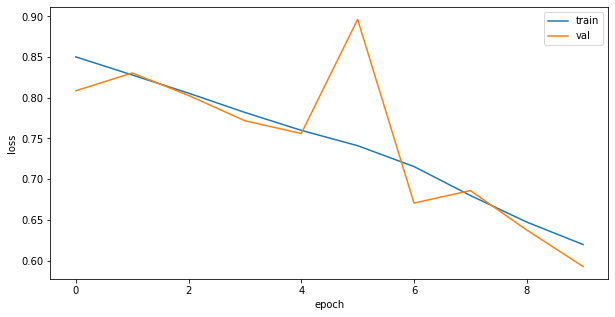

In [12]:
torch.cuda.empty_cache()

model, optimizer, scheduler = get_model_and_optimizer(device)

training_params =  {
    'num_epochs': 10, 
    'training_loader': training_loader, 
    'validation_loader': validation_loader,
    'model': model, 
    'optimizer': optimizer,
    'scheduler': False,
    'weights_stem':'whole_images_test_seg',
    'experiment':experiment,
    'verbose':True,
    'save_epoch':5
    
}

train(**training_params)

In [ ]:
# model, optimizer, scheduler = get_model_and_optimizer(device)
# model.load_state_dict(torch.load('weights/whole_images_train_epoch_2.pth'))

DICE:  tensor([[0.8539]], device='cuda:0')
IOU:  0.0


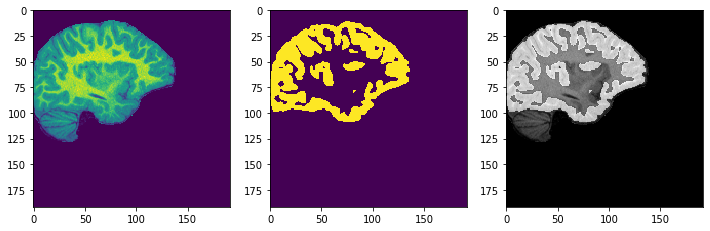

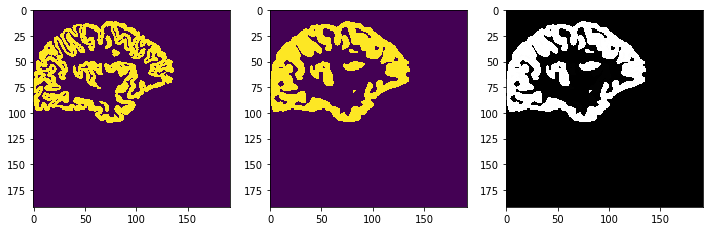

In [13]:
batch = next(iter(validation_loader))
model.eval()
inputs, targets = prepare_batch(batch, device)
with torch.no_grad():
    logits = forward(model, inputs)
labels = logits.argmax(dim=CHANNELS_DIMENSION)
foreground = labels[0].cpu().numpy().astype(np.uint8)
print('DICE: ', get_dice_score(targets, labels[0]))
print('IOU: ', get_iou_score(targets.cpu().numpy().astype(np.uint8), foreground))
plot_predicted(inputs, foreground, 30, title="An image")
plot_predicted(targets, foreground, 30, title="Segmentation")

### 1.2. Training with data patched data

In [80]:
import torchio

In [171]:
def get_torchio_dataset(inputs, targets):
    subjects = []
    for (image_path, label_path) in zip(inputs, targets ):
        subject_dict = {
            'MRI': torchio.Image(image_path, torchio.INTENSITY),
            'LABEL': torchio.Image(label_path, torchio.LABEL),
        }
        subject = torchio.Subject(subject_dict)
        subjects.append(subject)
    print('Dataset size:', len(subjects), 'subjects')
    return torchio.ImagesDataset(subjects)

from torchio import AFFINE, DATA, PATH, TYPE, STEM

def prepare_batch(batch, device):
    inputs = batch['MRI'][DATA].to(device)
    targets = batch['LABEL'][DATA]
    targets[targets > 0] = 1
    targets = targets.to(device)
    return inputs, targets

idx = training_idx
training_set = get_torchio_dataset(list(fcd_data.img_files[idx].values), list(fcd_data.img_seg[idx].values))
idx = validation_idx
validation_set= get_torchio_dataset(list(fcd_data.img_files[idx].values), list(fcd_data.img_seg[idx].values))

Dataset size: 10 subjects
Dataset size: 5 subjects


In [130]:
patch_size = 64
samples_per_volume = 8
max_queue_length = 240
training_batch_size = 16
validation_batch_size = 16

patches_training_set = torchio.Queue(
    subjects_dataset=training_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    patch_size=patch_size,
    sampler_class=torchio.sampler.ImageSampler,
    num_workers=multiprocessing.cpu_count(),
    shuffle_subjects=True,
    shuffle_patches=True,
)

patches_validation_set = torchio.Queue(
    subjects_dataset=validation_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    patch_size=patch_size,
    sampler_class=torchio.sampler.ImageSampler,
    num_workers=multiprocessing.cpu_count(),
    shuffle_subjects=False,
    shuffle_patches=False,
)

training_loader = torch.utils.data.DataLoader(
    patches_training_set, batch_size=training_batch_size)

validation_loader = torch.utils.data.DataLoader(
    patches_validation_set, batch_size=validation_batch_size)

Epoch 5 of 5 took 45.815s
  training loss (in-iteration): 	0.644260
  validation loss: 			0.794207


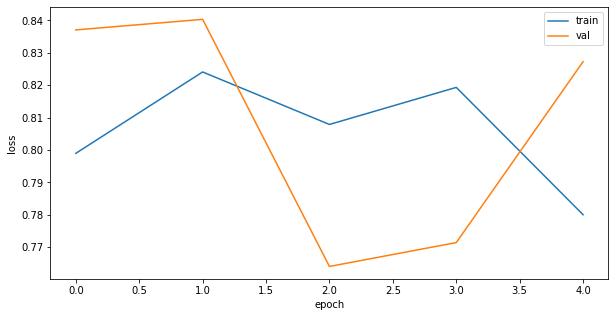

In [172]:
model, optimizer, scheduler = get_model_and_optimizer(device)

training_params =  {
    'num_epochs':5, 
    'training_loader':training_loader, 
    'validation_loader':validation_loader,
    'model': model, 
    'optimizer': optimizer,
    'scheduler':scheduler,
    'weights_stem':'patches',
    'experiment':False,
    'verbose':True
}

train(**training_params)

In [204]:
import nibabel as nib
sample = random.choice(validation_set)
input_tensor = sample['MRI'][DATA][0]
input_label = sample['LABEL'][DATA][0]
input_label[input_label > 0] = 1
input_label = input_label.byte()
patch_size = 64, 64, 64  # we can user larger patches for inference
patch_overlap = 4, 4, 4
grid_sampler = torchio.inference.GridSampler(
    sample,
    patch_size,
    patch_overlap,
)
patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=validation_batch_size)
aggregator = torchio.inference.GridAggregator(
    sample,
    patch_overlap,
)

model.eval()
with torch.no_grad():
    for patches_batch in patch_loader:
        inputs = patches_batch['MRI'][DATA].to(device)
        locations = patches_batch['location']
        logits = model(inputs)
        labels = logits.argmax(dim=CHANNELS_DIMENSION, keepdim=True)
        aggregator.add_batch(labels, locations)

predicted = aggregator.get_output_tensor()

/gpfs/data/opt/python-3.6.8/lib/python3.6/site-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


DICE:  tensor(0.8700)
IOU:  0.769874739344095


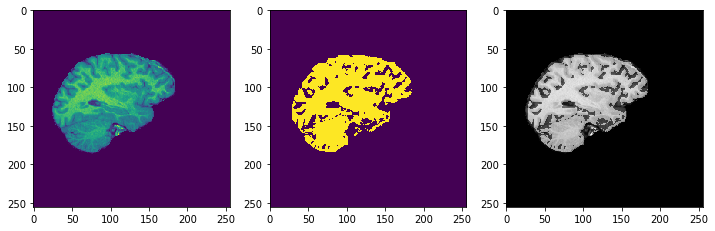

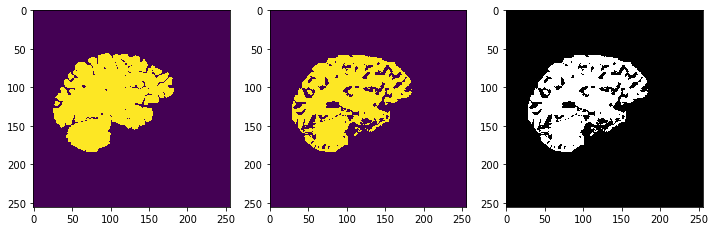

In [211]:
print('DICE: ', get_dice_score(predicted[0], input_label))
print('IOU: ', get_iou_score(predicted[0].cpu().numpy().astype(np.uint8), input_label.cpu().numpy()))
plot_predicted(input_tensor.cpu().numpy(), predicted[0].cpu().numpy(), 30, title="An image")
plot_predicted(input_label.cpu().numpy(), predicted[0].cpu().numpy(), 30, title="Segmentation")

### 3. Augmentation

In [73]:
import torchio

MRI = 'MRI'
LABEL = 'LABEL'

def get_torchio_dataset(inputs, targets, transform = False):
    subjects = []
    for (image_path, label_path) in zip(inputs, targets ):
        subject_dict = {
            MRI : torchio.Image(image_path, torchio.INTENSITY),
            LABEL: torchio.Image(label_path, torchio.LABEL),
        }
        subject = torchio.Subject(subject_dict)
        subjects.append(subject)
    print('Dataset size:', len(subjects), 'subjects')
    
    if transform:
        dataset = torchio.ImagesDataset(subjects, transform = transform)
    elif not transform:
        dataset = torchio.ImagesDataset(subjects)
    
    return  dataset

from torchio import AFFINE, DATA, PATH, TYPE, STEM

def prepare_batch(batch, device):
    inputs = batch[MRI][DATA].to(device)
    targets = batch[MRI][DATA]
    targets[targets > 0] = 1
    targets = targets.to(device)
    return inputs, targets

In [38]:
from torchio.transforms import HistogramStandardization

histogram_landmarks_path = 'weights/fcd_landmarks.npy'

image_paths = list(fcd_data.img_files.values)

landmarks = HistogramStandardization.train(
    image_paths,
    output_path=histogram_landmarks_path,
)
print(landmarks.shape)

100%|██████████| 15/15 [00:09<00:00,  1.64it/s]

(13,)


In [76]:
from torchio.transforms import (
    RandomFlip,
    RandomAffine,
    RandomElasticDeformation,
    RandomNoise,
    RandomMotion,
    RandomBiasField,
    RescaleIntensity,
    Resample,
    ToCanonical,
    ZNormalization,
    CropOrPad,
    HistogramStandardization,
    OneOf,
    Compose,
)

training_transform = Compose([
    RescaleIntensity((0, 1)),  # so that there are no negative values for RandomMotion
#     RandomMotion(),
    HistogramStandardization(landmarks_dict={MRI: landmarks}),
    RandomBiasField(),
    ZNormalization(masking_method=ZNormalization.mean),
    CropOrPad((192, 192, 192)),
#     RandomFlip(axes=(0,)),
#     OneOf({
#         RandomAffine(): 0.8,
#         RandomElasticDeformation(): 0.2,
#     }),
])

validation_transform = Compose([
    HistogramStandardization(landmarks_dict={MRI: landmarks}),
    ZNormalization(masking_method=ZNormalization.mean),
    CropOrPad((192, 192, 192)),
])

In [77]:
from sklearn.model_selection import StratifiedKFold, ShuffleSplit
from torch.utils.data import DataLoader, Subset
import warnings
from unet import UNet

import multiprocessing

# Config
seed = 42
num_epochs = 5
batch_size = 1

cv = ShuffleSplit(n_splits=1,  test_size = 0.3, random_state=42)
cv_splits = list(cv.split(X=np.arange(len(fcd_data)), y=fcd_data.target))
training_idx, validation_idx = cv_splits[0]


idx = training_idx
training_set = get_torchio_dataset(list(fcd_data.img_files[idx].values), list(fcd_data.img_seg[idx].values))
idx = validation_idx
validation_set= get_torchio_dataset(list(fcd_data.img_files[idx].values), list(fcd_data.img_seg[idx].values))

Dataset size: 10 subjects
Dataset size: 5 subjects


In [82]:
patch_size = 64
samples_per_volume = 8
max_queue_length = 160
training_batch_size = 4
validation_batch_size = 4

patches_training_set = torchio.Queue(
    subjects_dataset=training_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    patch_size=patch_size,
    sampler_class=torchio.sampler.ImageSampler,
    num_workers=multiprocessing.cpu_count(),
    shuffle_subjects=True,
    shuffle_patches=True,
)

patches_validation_set = torchio.Queue(
    subjects_dataset=validation_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    patch_size=patch_size,
    sampler_class=torchio.sampler.ImageSampler,
    num_workers=multiprocessing.cpu_count(),
    shuffle_subjects=False,
    shuffle_patches=False,
)

training_loader = torch.utils.data.DataLoader(
    patches_training_set, batch_size=training_batch_size)

validation_loader = torch.utils.data.DataLoader(
    patches_validation_set, batch_size=validation_batch_size)

Epoch 10 of 10 took 140.729s
  training loss (in-iteration): 	0.759888
  validation loss: 			0.747544


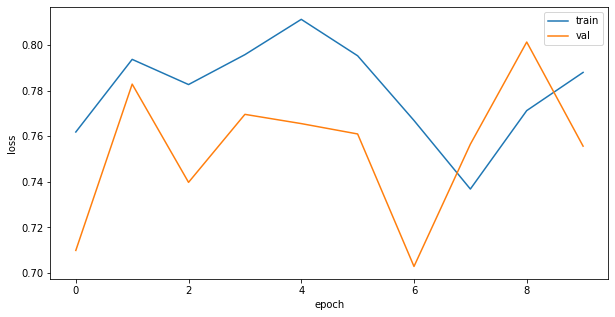

In [88]:
torch.cuda.empty_cache()

# model, optimizer, scheduler = get_model_and_optimizer(device)

training_params =  {
    'num_epochs':10, 
    'training_loader':training_loader, 
    'validation_loader':validation_loader,
    'model': model, 
    'optimizer': optimizer,
    'scheduler':scheduler,
    'weights_stem':'patches',
    'experiment':False,
    'verbose':True
}

train(**training_params)

In [89]:
import nibabel as nib
sample = random.choice(validation_set)
input_tensor = sample['MRI'][DATA][0]
input_label = sample['LABEL'][DATA][0]
input_label[input_label > 0] = 1
input_label = input_label.byte()
patch_size = 64, 64, 64  # we can user larger patches for inference
patch_overlap = 4, 4, 4
grid_sampler = torchio.inference.GridSampler(
    sample,
    patch_size,
    patch_overlap,
)
patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=validation_batch_size)
aggregator = torchio.inference.GridAggregator(
    sample,
    patch_overlap,
)

model.eval()
with torch.no_grad():
    for patches_batch in patch_loader:
        inputs = patches_batch['MRI'][DATA].to(device)
        locations = patches_batch['location']
        logits = model(inputs)
        labels = logits.argmax(dim=CHANNELS_DIMENSION, keepdim=True)
        aggregator.add_batch(labels, locations)

predicted = aggregator.get_output_tensor()

/gpfs/data/opt/python-3.6.8/lib/python3.6/site-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [90]:
def get_dice_score(output, target, SPATIAL_DIMENSIONS = (2, 3, 4), epsilon=1e-9):
    p0 = output
    g0 = target
    p1 = 1 - p0
    g1 = 1 - g0
    tp = (p0 * g0).sum()
    fp = (p0 * g1).sum()
    fn = (p1 * g0).sum()
    num = 2 * tp
    denom = 2 * tp + fp + fn + epsilon
    dice_score = num / denom
    return dice_score

DICE:  0.38118222
IOU:  0.2354694991383253


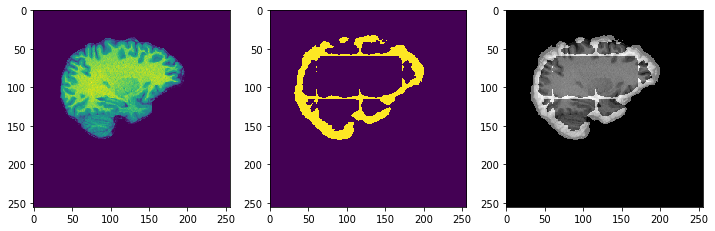

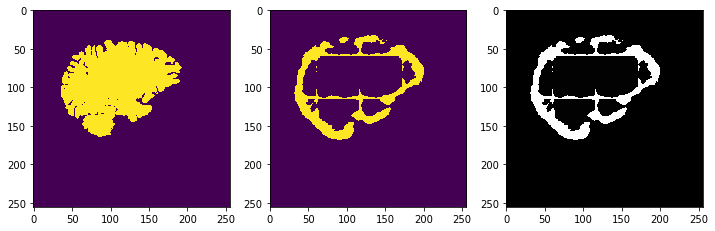

In [93]:
print('DICE: ', get_dice_score(predicted[0], input_label).cpu().numpy())
print('IOU: ', get_iou_score(predicted[0].cpu().numpy().astype(np.uint8), input_label.cpu().numpy()))
plot_predicted(input_tensor.cpu().numpy(), predicted[0].cpu().numpy(), 30, title="An image")
plot_predicted(input_label.cpu().numpy(), predicted[0].cpu().numpy(), 30, title="Segmentation")

In [ ]:
def cross_val_score(cnn_model, train_dataset, cv, device, metric, 
                    model_load_path=None, batch_size=10, val_dataset=None, transfer=False, 
                    finetune=False, experiment = False, max_epoch=20):
    
    assert not (transfer and finetune)
    assert (transfer == False) or (transfer == True and model_load_path is not None)

    use_rest = True
    if val_dataset is None:  # smri case or fmri case without rest
        val_dataset = train_dataset
        use_rest = False

    cv_splits = list(cv.split(X=np.arange(len(train_dataset)), y=train_dataset.target))
    val_metrics = []

    for i in range(len(cv_splits)):
        train_idx, val_idx = cv_splits[i]

        # train data
        if model_load_path is None or transfer or finetune:
            train_idx = stratified_batch_indices(train_idx, train_dataset.target[train_idx])
            train_loader = DataLoader(Subset(train_dataset, train_idx),
                                      shuffle=False,
                                      batch_size=batch_size,
                                      drop_last=False)

        # val data
        if use_rest:
            val_mask = (np.isin(val_dataset.pids, train_dataset.pids[train_idx]) == False)
            val_idx = np.arange(len(val_dataset))[val_mask]
            del val_mask
        
        val_loader = DataLoader(Subset(val_dataset, val_idx),
                                shuffle=False,
                                batch_size=batch_size,
                                drop_last=False)

        eps = 1e-2 if use_rest else 3e-3
        model, optimizer, scheduler = create_model_opt(cnn_model)
        
        _, _, _, last_val_metric = train(model, optimizer, scheduler,
                                         train_loader, val_loader, device,
                                        metric=metric, 
                                        verbose=1,  
                                        max_epoch=max_epoch,
                                        eps=eps,
                                        experiment=experiment)
        
        val_metrics.append(last_val_metric)
                
        if model_load_path:  # no train, just validation
            model, optimizer = create_model_opt(model_load_path, transfer=False)
            criterion = nn.CrossEntropyLoss()
            with torch.no_grad():
                val_losses, val_probs, val_targets = run_one_epoch(
                    model, val_loader, criterion, False, device, scheduler)
            val_metric = metric(val_targets, val_probs)
            val_metrics.append(val_metric)
            
        del train_loader, val_loader, model, optimizer, scheduler

    return val_metrics

In [ ]:
# plot batches

experiment.set_name("Patch based, 64 batch")